 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"></ul></div>

In [1]:
import scanpy.api as sc
import pandas as pd
import loompy
import numpy as np
import anndata as ad

In [2]:
def pandas_into_adata(dataset):
    var_seq = pd.DataFrame(index=dataset.index)
    obs_seq = pd.DataFrame(index=dataset.columns)
    X_seq = dataset.values.T
    adata_seq = ad.AnnData(X_seq, obs=obs_seq, var=var_seq)
    return adata_seq


In [3]:
# Load 1st ile
seqwell = pd.read_table("/Users/dariapodorskaja/Downloads/IntegratedAnalysis_ExpressionMatrices/pbmc_SeqWell.expressionMatrix.txt")

In [4]:
adata_seq = pandas_into_adata(seqwell)

In [5]:
adata_seq.write_loom('seqwell_transposed.loom')

In [6]:
# Load 2nd file 
tenx = pd.read_table("/Users/dariapodorskaja/Downloads/IntegratedAnalysis_ExpressionMatrices/pbmc_10X.expressionMatrix.txt")

In [7]:
adata_tenx = pandas_into_adata(tenx)

In [8]:
adata_tenx.write_loom("tenx_transposed.loom")

In [9]:
seqwell = sc.read_loom("/Users/dariapodorskaja/Documents/_Seurat_into_MNN/seqwell_transposed.loom")

In [10]:
adata = seqwell.X

In [11]:
type(adata)

numpy.ndarray

In [12]:
type(seqwell)

anndata.base.AnnData

In [13]:
seqwell.var_names = [ name[0] for name in seqwell.var.values.tolist() ]

In [14]:
seqwell.var_names

Index(['AAED1', 'AAGAB', 'AAK1', 'AAMP', 'AARS', 'AASDHPPT', 'AATF', 'ABCA1',
       'ABCA7', 'ABCB1',
       ...
       'ZRANB1', 'ZRANB2', 'ZRSR2', 'ZSCAN16-AS1', 'ZSWIM6', 'ZSWIM8',
       'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3'],
      dtype='object', length=6713)

In [15]:
seqwell.var_names_make_unique()

In [16]:
sc.pp.filter_cells(seqwell, min_genes=200)
sc.pp.filter_genes(seqwell, min_cells=3)

In [17]:
seqwell.raw = sc.pp.log1p(seqwell, copy=True)

In [18]:
mito_genes = [name for name in seqwell.var_names if name.startswith('MT-')]

In [19]:
mito_genes

['MT-ATP6',
 'MT-ATP8',
 'MT-CO1',
 'MT-CO2',
 'MT-CO3',
 'MT-CYB',
 'MT-ND1',
 'MT-ND2',
 'MT-ND3',
 'MT-ND4',
 'MT-ND4L',
 'MT-ND5',
 'MT-ND6',
 'MT-RNR1',
 'MT-RNR2',
 'MT-TF',
 'MT-TG',
 'MT-TH',
 'MT-TI',
 'MT-TL1',
 'MT-TL2',
 'MT-TM',
 'MT-TP',
 'MT-TR',
 'MT-TS2',
 'MT-TT',
 'MT-TV']

In [20]:
adata

array([[0.        , 0.        , 1.1528707 , ..., 0.5764353 , 2.3057413 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.63443726],
       [0.        , 0.        , 0.        , ..., 2.0663292 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 5.561735  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [21]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
seqwell.obs['percent_mito'] = np.sum(
    seqwell[:, mito_genes].X, axis=1) / np.sum(seqwell.X, axis=1)
# add the total counts per cell as observations-annotation to adata
seqwell.obs['n_counts'] = seqwell.X.sum(axis=1)

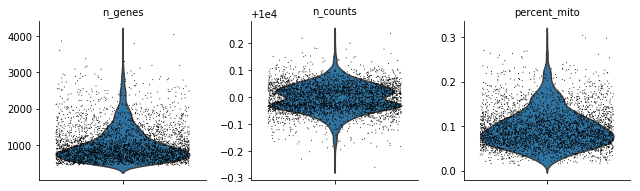

In [22]:
sc.pl.violin(seqwell, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

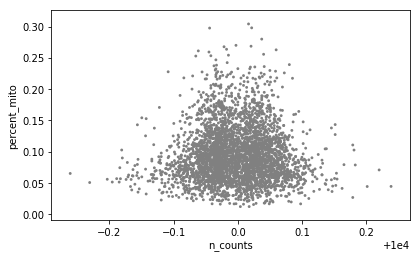

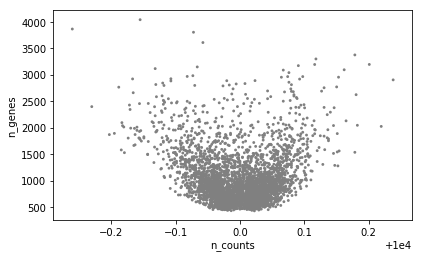

In [23]:
sc.pl.scatter(seqwell, x='n_counts', y='percent_mito')
sc.pl.scatter(seqwell, x='n_counts', y='n_genes')

In [24]:
seqwell = seqwell[seqwell.obs['n_genes'] < 2500, :]
seqwell = seqwell[seqwell.obs['percent_mito'] < 0.05, :]

In [25]:
seqwell.raw = sc.pp.log1p(seqwell, copy=True)


In [26]:
sc.pp.normalize_per_cell(seqwell, counts_per_cell_after=1e4)

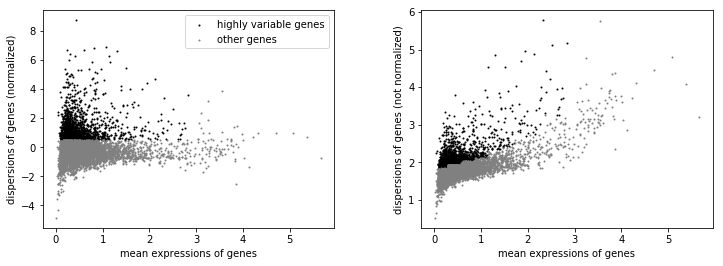

In [27]:
filter_result = sc.pp.filter_genes_dispersion(
    seqwell.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [28]:
seqwell = seqwell[:, filter_result.gene_subset]


In [29]:
sc.tl.pca(seqwell)

In [30]:
sc.pp.log1p(seqwell)

In [31]:
sc.pp.regress_out(seqwell, ['n_counts', 'percent_mito'])

In [32]:
sc.pp.scale(seqwell, max_value=10)

In [33]:
#PCA
sc.tl.pca(seqwell)


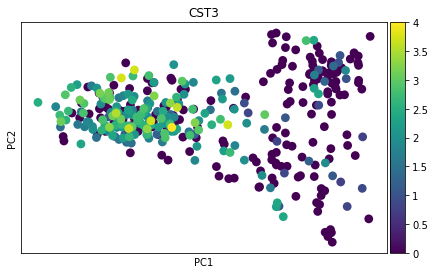

In [34]:
seqwell.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(seqwell, color='CST3')

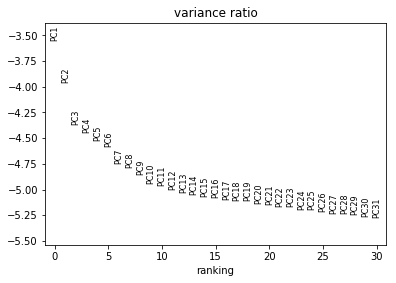

In [35]:
sc.pl.pca_variance_ratio(seqwell, log=True)

In [36]:
seqwell

AnnData object with n_obs × n_vars = 390 × 1478 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'Genes', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [37]:
#TSNE 

In [38]:
sc.tl.tsne(seqwell, random_state=2, n_pcs=10)

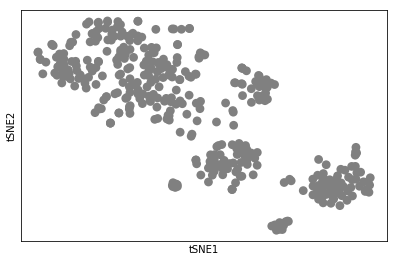

In [39]:
sc.pl.tsne(seqwell)

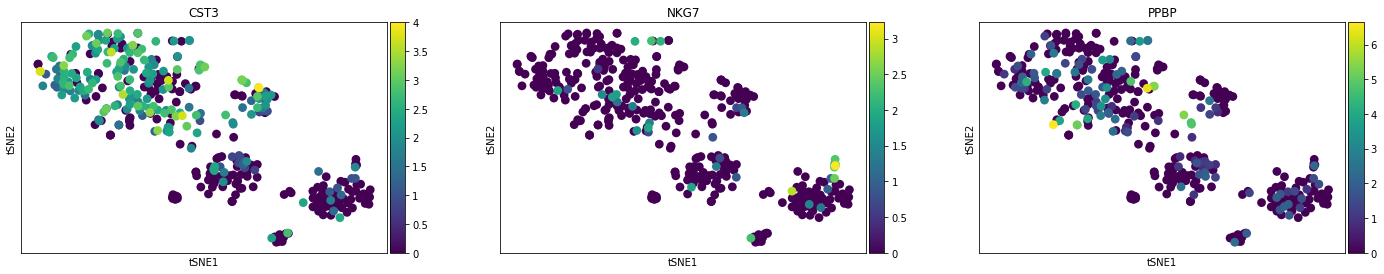

In [40]:
sc.pl.tsne(seqwell, color=['CST3', 'NKG7', 'PPBP'])

In [41]:
#Computing the neighborhood graph¶
sc.pp.neighbors(seqwell, n_neighbors=10)

/anaconda3/lib/python3.6/site-packages/scanpy/neighbors/__init__.py:123: RuntimeWarning: invalid value encountered in sqrt
  distances = np.sqrt(distances)


In [42]:
sc.tl.umap(seqwell)

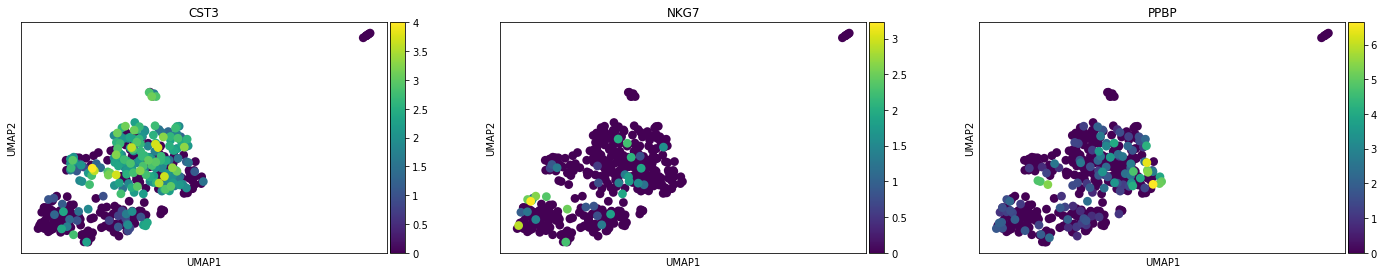

In [43]:
sc.pl.umap(seqwell, color=['CST3', 'NKG7', 'PPBP'])

In [44]:
sc.pl.umap(seqwell, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

ValueError: key 'CST3' is invalid! pass valid observation annotation, one of ['n_genes', 'percent_mito', 'n_counts'] or a gene name Index(['AAGAB', 'AAK1', 'ABCA1', 'ABCB1', 'ABCG1', 'ABI1', 'ABLIM1', 'ABT1',
       'AC006129.2', 'AC007161.5',
       ...
       'ZNF721', 'ZNF766', 'ZNF770', 'ZNF808', 'ZNF830', 'ZNF844', 'ZNF90',
       'ZNRF2', 'ZRANB1', 'ZSCAN16-AS1'],
      dtype='object', length=1478)

In [45]:
#Clustering the graph

In [46]:
from igraph import Graph

In [47]:
import louvain

In [48]:
sc.tl.louvain(seqwell)

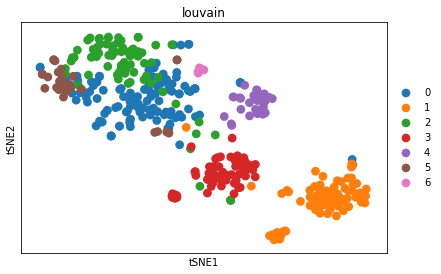

In [49]:
sc.pl.tsne(seqwell, color='louvain')

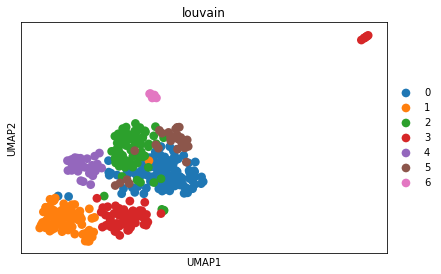

In [50]:
sc.pl.umap(seqwell, color='louvain')

In [51]:
#Finding marker genes

saving figure to file ./figures/rank_genes_groups_louvain.pdf


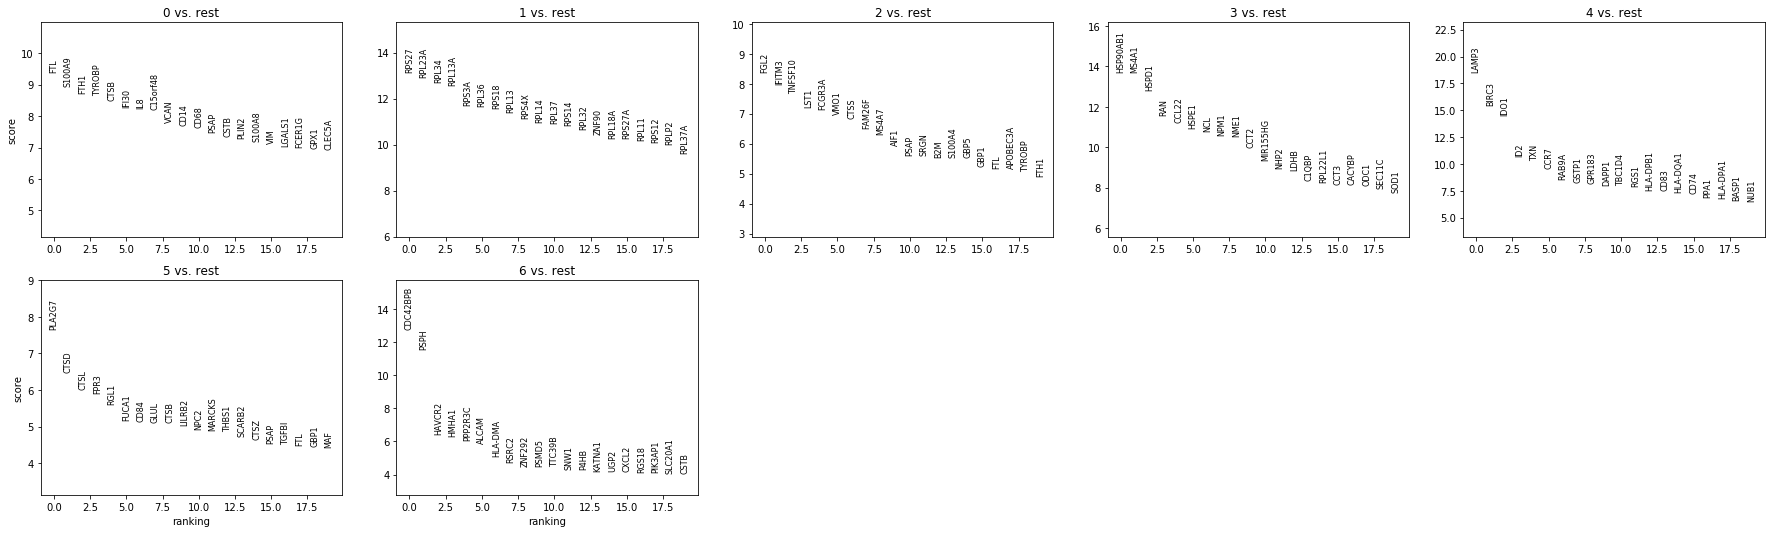

In [52]:
sc.tl.rank_genes_groups(seqwell, 'louvain')
sc.pl.rank_genes_groups(seqwell, n_genes=20, save='.pdf')

In [53]:
sc.settings.verbosity = 2  # reduce the verbosity to no longer see hints

ranking genes
    finished (0:00:00.68)


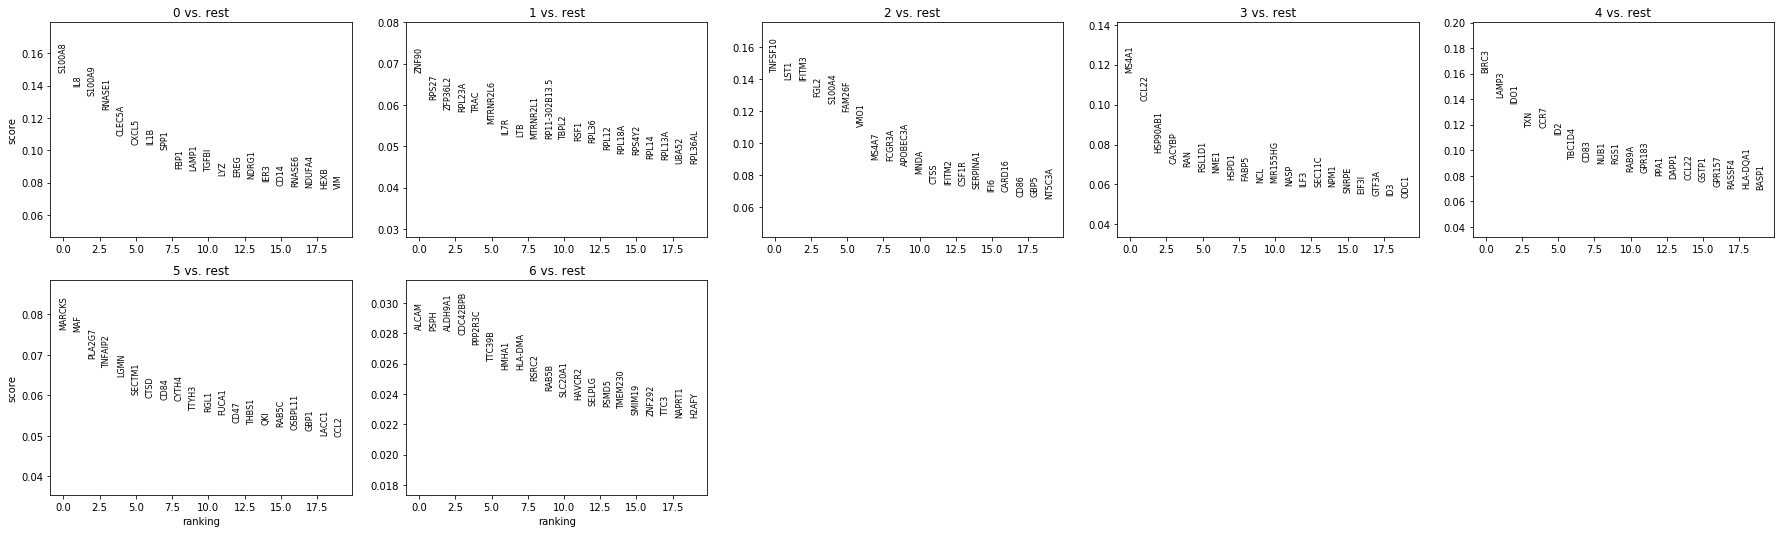

In [54]:
sc.tl.rank_genes_groups(seqwell, 'louvain', method='logreg')
sc.pl.rank_genes_groups(seqwell, n_genes=20)

In [55]:
pd.DataFrame(seqwell.uns['rank_genes_groups']['names']).head(5)


,0,1,2,3,4,5,6
0,S100A8,ZNF90,TNFSF10,MS4A1,BIRC3,MARCKS,ALCAM
1,IL8,RPS27,LST1,CCL22,LAMP3,MAF,PSPH
2,S100A9,ZFP36L2,IFITM3,HSP90AB1,IDO1,PLA2G7,ALDH9A1
3,RNASE1,RPL23A,FGL2,CACYBP,TXN,TNFAIP2,CDC42BPB
4,CLEC5A,TRAC,S100A4,RAN,CCR7,LGMN,PPP2R3C


In [56]:
result = seqwell.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores']}).head(5)

,0_n,0_s,1_n,1_s,2_n,2_s,3_n,3_s,4_n,4_s,5_n,5_s,6_n,6_s
0,S100A8,0.148353,ZNF90,0.067987,TNFSF10,0.144546,MS4A1,0.116336,BIRC3,0.161316,MARCKS,0.076229,ALCAM,0.028247
1,IL8,0.139401,RPS27,0.061412,LST1,0.139905,CCL22,0.102340,LAMP3,0.141539,MAF,0.075857,PSPH,0.028198
2,S100A9,0.133749,ZFP36L2,0.058926,IFITM3,0.139316,HSP90AB1,0.076286,IDO1,0.137006,PLA2G7,0.069166,ALDH9A1,0.028178
3,RNASE1,0.125381,RPL23A,0.058401,FGL2,0.129436,CACYBP,0.070409,TXN,0.118098,TNFAIP2,0.066995,CDC42BPB,0.027970
4,CLEC5A,0.108999,TRAC,0.058242,S100A4,0.124883,RAN,0.069155,CCR7,0.117754,LGMN,0.064762,PPP2R3C,0.027313


ranking genes
    finished (0:00:00.03)


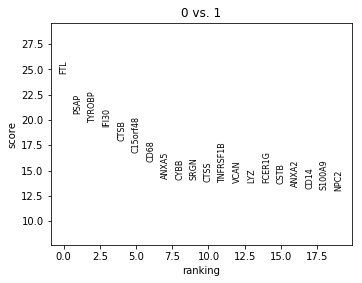

In [57]:
sc.tl.rank_genes_groups(seqwell, 'louvain', groups=['0'], reference='1')
sc.pl.rank_genes_groups(seqwell, groups=['0'], n_genes=20)

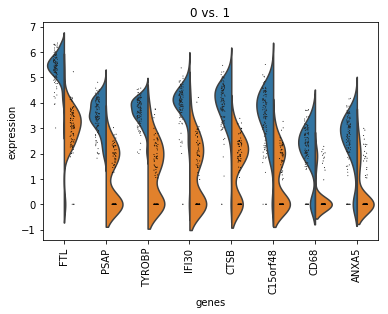

In [58]:
sc.pl.rank_genes_groups_violin(seqwell, groups='0', n_genes=8)

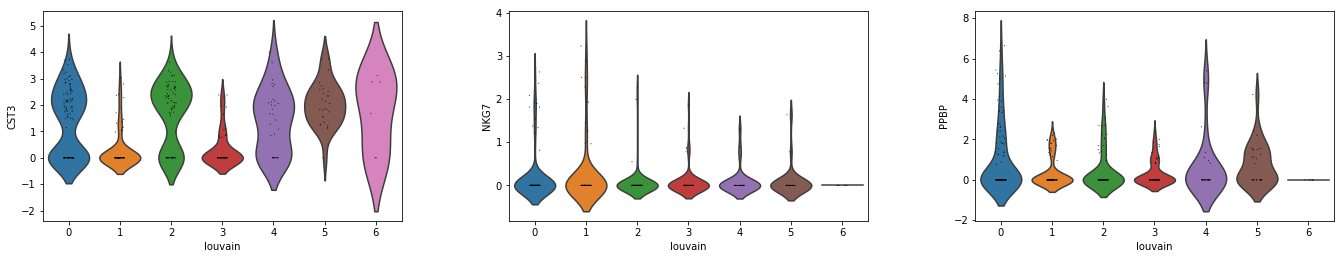

In [59]:
sc.pl.violin(seqwell, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')